# To build and train resnet, use the pytorch

In [1]:
import os
import time
from datetime import datetime

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from accelerate import Accelerator
from evaluate import load
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

In [2]:
# Set device
accelerator = Accelerator(device_placement=True)
device = accelerator.device

In [3]:
# Define hyperparameters
num_epochs = 70
batch_size = 2 ** 7

In [4]:
# weights = models.ResNet50_Weights.DEFAULT

In [5]:
norm = transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    norm,
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    norm,
])

In [6]:
# Load CIFAR-100 dataset
train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


Files already downloaded and verified
(10000, 32, 32, 3)


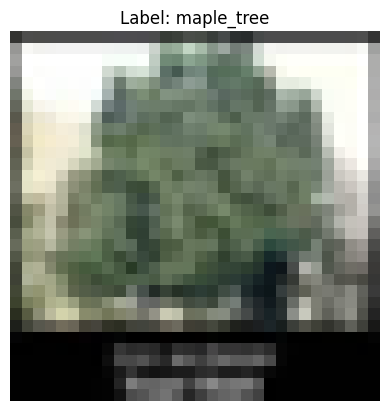

maple_tree


In [7]:
d = datasets.CIFAR100(root='./data', train=False, download=True)
print(f'{d.data.shape}')

# Randomly select an image from the training dataset
index = np.random.randint(0, len(d))
image, label = d[index]
target = d.classes[label]

# Plot the image
plt.imshow(image)
plt.title(f"Label: {target}")
plt.axis('off')
plt.show()
print(target)

del index, image, label, target, plt, d

In [8]:
# Load model architecture.
model = models.resnet50(weights=None)
# model.eval()

model.fc = nn.Linear(model.fc.in_features, 100)  # resnet

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

model, optimizer, scheduler, train_dataloader, test_dataloader = accelerator.prepare(
    model, optimizer, scheduler, train_dataloader, test_dataloader
)

In [9]:
# Load evaluation metrics
accuracy = load("accuracy")
f1 = load("f1")

In [10]:
training_result = []

# Training loop
for epoch in range(num_epochs):
    tic = datetime.now()

    model.train()

    train_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        accelerator.backward(loss)
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss /= len(train_dataloader)

    model.eval()
    test_loss = 0.0
    test_preds = []
    test_labels = []
    test_total_time = 0.

    with torch.no_grad():
        for images, labels in test_dataloader:
            test_tic = time.time()

            outputs = model(images)

            test_total_time += (time.time() - test_tic) * 1000

            loss = criterion(outputs, labels)
            test_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            test_preds.extend(accelerator.gather(preds).cpu().numpy())
            test_labels.extend(accelerator.gather(labels).cpu().numpy())

    test_loss /= len(test_dataloader)
    test_acc = accuracy.compute(references=test_labels, predictions=test_preds)["accuracy"]
    test_f1 = f1.compute(references=test_labels, predictions=test_preds, average="macro")["f1"]

    # Update the learning rate based on validation loss
    scheduler.step()

    # Time calculation
    toc = datetime.now()
    elapsed_time = toc - tic
    elapsed_time_in_hh_mm_ss = str(elapsed_time).split('.')[0]

    print(
        f"Epoch [{epoch + 1}/{num_epochs}]: Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, "
        f'Train Accuracy: {correct / total:.3f}, '
        f"Test Accuracy: {test_acc:.4f}, Test F1: {test_f1:.4f}, "
        f'lr: {optimizer.param_groups[0]["lr"]}, '
        f'Elapsed Time: {elapsed_time_in_hh_mm_ss}, '
        f'Average Ineference Time: {test_total_time / len(test_dataloader):.3f} ms.\n'
    )

    training_result.append({
        'train_loss': train_loss,
        'test_loss': test_loss,
        'train_acc': correct / total,
        'test_acc': test_acc,
        'lr': optimizer.param_groups[0]["lr"],
        'average_ineference_time': test_total_time / len(test_dataloader),
    })

Epoch [1/70]: Train Loss: 4.4598, Test Loss: 3.8419, Train Accuracy: 0.062, Test Accuracy: 0.1160, Test F1: 0.0820, lr: 0.009999383162408303, Elapsed Time: 0:00:22, Average Ineference Time: 7.270 ms.
Epoch [2/70]: Train Loss: 3.7961, Test Loss: 3.6095, Train Accuracy: 0.125, Test Accuracy: 0.1652, Test F1: 0.1397, lr: 0.009997532801828657, Elapsed Time: 0:00:21, Average Ineference Time: 6.606 ms.
Epoch [3/70]: Train Loss: 3.5226, Test Loss: 3.4005, Train Accuracy: 0.165, Test Accuracy: 0.2100, Test F1: 0.1919, lr: 0.00999444937480985, Elapsed Time: 0:00:21, Average Ineference Time: 6.674 ms.
Epoch [4/70]: Train Loss: 3.3148, Test Loss: 3.2266, Train Accuracy: 0.199, Test Accuracy: 0.2307, Test F1: 0.2115, lr: 0.009990133642141357, Elapsed Time: 0:00:21, Average Ineference Time: 6.799 ms.
Epoch [5/70]: Train Loss: 3.1751, Test Loss: 3.1638, Train Accuracy: 0.222, Test Accuracy: 0.2504, Test F1: 0.2293, lr: 0.009984586668665639, Elapsed Time: 0:00:21, Average Ineference Time: 6.590 ms.
E

In [11]:
# index is epoch number.
tr = pd.DataFrame(training_result,
                  columns=['train_loss', 'test_loss', 'train_acc', 'test_acc', 'lr', 'average_ineference_time'])
tr.to_csv('resnet_cifar100_result.csv')
tr

,train_loss,test_loss,train_acc,test_acc,lr,average_ineference_time
0,4.459843,3.841901,0.06226,0.1160,0.009999,7.270007
1,3.796108,3.609528,0.12502,0.1652,0.009998,6.605876
2,3.522557,3.400485,0.16496,0.2100,0.009994,6.673725
3,3.314821,3.226610,0.19888,0.2307,0.009990,6.799284
4,3.175116,3.163781,0.22164,0.2504,0.009985,6.589603
...,...,...,...,...,...,...
65,0.417963,2.368408,0.87290,0.4814,0.007545,6.530822
66,0.417410,2.373769,0.87434,0.4891,0.007477,6.409265
67,0.420677,2.323763,0.87468,0.4942,0.007409,6.596900
68,0.407904,2.377791,0.87768,0.4849,0.007340,6.696179


In [12]:
torch.save(model.state_dict(), 'resnet_cifar100.pth')
# Get the size of the saved model file
model_size = os.path.getsize('resnet_cifar100.pth') / (1024 * 1024)  # Size in MB
print(f"Pruned model size: {model_size:.2f} MB")

Pruned model size: 90.76 MB
